In [1]:
import sys
print(sys.executable)
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

/work/submit/anton100/msci-project/smart-pixels-ml/venv/bin/python
True NVIDIA A30


In [2]:
import sys
import pathlib
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, Callback
import random
from pathlib import Path
import time
import argparse
import json
import submitit
import shutil
from OptimizedDataGenerator import OptimizedDataGenerator
from loss import custom_loss
from models import CreateModel
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
epochs = 200
batch_size = 256
val_batch_size = 256
train_file_size = 20
val_file_size = 5
n_filters = 5
pool_size = 3
learning_rate = 0.001
early_stopping_patience = 50
shape=(13,21,2)

In [3]:


# paths
data_directory_path = "/ceph/submit/data/user/a/anton100/datasets/recon3D/" # "/net/scratch/badea/dataset8/unflipped/"
labels_directory_path = "/ceph/submit/data/user/a/anton100/datasets/labels/" # "/net/scratch/badea/dataset8/unflipped/"

# create tf records directory
# stamp = '%08x' % random.randrange(16**8)
stamp = "3e778b82"
output_directory = Path(f"./tfrecords_{stamp}").resolve()
os.makedirs(output_directory, exist_ok=True)
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()
tfrecords_dir_test = Path(output_directory, f"tfrecords_test_{stamp}").resolve()

In [ ]:
# Trainning Generator
start_time = time.time()
training_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    file_count = train_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    save=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_train,
)
print(f"Training data generator created in {time.time() - start_time} seconds.")

start_time = time.time()
validation_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    file_count = val_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    files_from_end=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_validation,
)
print(f"Validation data generator created in {time.time() - start_time} seconds.")

# data generator (TEST)
start_time = time.time()

test_generator = OptimizedDataGenerator(
        data_directory_path = data_directory_path,
        labels_directory_path = labels_directory_path,
        is_directory_recursive = False,
        file_type = "parquet",
        data_format = "3D",
        batch_size = val_batch_size,
        file_count = val_file_size,
        to_standardize= True,
        include_y_local= False,
        labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
        input_shape = (2,13,21), # (20,13,21),
        transpose = (0,2,3,1),
        files_from_end=True,
        use_time_stamps = [0,19],
        tfrecords_dir = tfrecords_dir_test,
    )

print(f"Test data generator created in {time.time() - start_time} seconds.")

Directory /work/submit/anton100/msci-project/smart-pixels-ml/tfrecords_3e778b82/tfrecords_train_3e778b82 does not exist and cannot be removed.
Found 20 files to process
First file: /ceph/submit/data/user/a/anton100/datasets/recon3D/recon3D_d17301.parquet


Processing Files...:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Processing Files...:  45%|██████████████████████████████████▋                                          | 9/20 [00:17<00:21,  1.96s/it]

In [9]:
training_generator = OptimizedDataGenerator(
load_from_tfrecords_dir = f"/home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_{stamp}/tfrecords_train_{stamp}/",
shuffle = True,
seed = 13,
quantize = True
)

validation_generator = OptimizedDataGenerator(
load_from_tfrecords_dir = f"/home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_{stamp}/tfrecords_validation_{stamp}/",
shuffle = True,
seed = 13,
quantize = True
)

test_generator = OptimizedDataGenerator(
load_from_tfrecords_dir= f"/home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_{stamp}/tfrecords_test_{stamp}/",
shuffle = True,
seed = 13,
quantize = True
)

In [10]:
model = CreateModel(shape=shape, n_filters=5, pool_size=3)
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [11]:
checkpoint_directory = Path(f"./checkpoints_{stamp}").resolve()
checkpoint_directory.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist
checkpoint_filepath = Path(checkpoint_directory, 'weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5').resolve()

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=False,
)

csvlogger_directory = Path("./csvlogs").resolve()
csvlogger_directory.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

csv_logger = CSVLogger(Path(csvlogger_directory, f'training_log_{stamp}.csv').resolve(), append=True)

In [12]:
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    callbacks=[es, mcp, csv_logger],
                    epochs=epochs,
                    shuffle=False, # shuffling now occurs within the data-loader
                    verbose=1)

Epoch 1/200
3905/3905 [==============================] - 317s 80ms/step - loss: 223.9819 - val_loss: -652.5705
Epoch 2/200
1070/3905 [=======>......................] - ETA: 2:42 - loss: -646.5292

KeyboardInterrupt: 

In [13]:
minval = 1e-9

# --- Select the most recent weights file ---
weights_path = sorted(checkpoint_directory.glob('weights.*.hdf5'))[-1]
print(f"Using weights: {weights_path.name}")

# --- Create output directory for this stamp ---
outfile_directory = Path(f"./outfile_{stamp}").resolve()
outfile_directory.mkdir(parents=True, exist_ok=True)  # make folder if needed

# --- Name the CSV file after the weights file, with evaluation prefix ---
outfile_name = f"evaluation_results_{weights_path.stem}.csv"
outfile_path = outfile_directory / outfile_name



n_filters = 5
pool_size = 3
shape=(13,21,2)


# --- Handle job ID substitution (optional) ---
try:
    job_env = submitit.JobEnvironment()
    outfile_path = Path(str(outfile_path).replace("%j", str(job_env.job_id)))
except:
    outfile_path = Path(str(outfile_path).replace("%j", "%08x" % random.randrange(16**8)))

# --- Make sure output directory exists ---
os.makedirs(outfile_directory, exist_ok=True)
print(f"Output file will be saved to: {outfile_path}")

# ------------------------------------------------------------
#  Model evaluation
# ------------------------------------------------------------

model = CreateModel(shape=shape, n_filters=n_filters, pool_size=pool_size)
model.load_weights(weights_path)
p_test = model.predict(test_generator)

# Collect all true labels
complete_truth = None
for _, y in test_generator:
    complete_truth = y if complete_truth is None else np.concatenate((complete_truth, y), axis=0)

# Build DataFrame
df = pd.DataFrame(
    p_test,
    columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43']
)

# Add true labels
df['xtrue'], df['ytrue'], df['cotAtrue'], df['cotBtrue'] = complete_truth.T

# Clamp diagonal matrix elements to >= minval
for m in ['M11','M22','M33','M44']:
    df[m] = minval + tf.math.maximum(df[m], 0)

# Compute residuals
df['residual_x']  = df['xtrue']    - df['x']
df['residual_y']  = df['ytrue']    - df['y']
df['residual_A']  = df['cotAtrue'] - df['cotA']
df['residual_B']  = df['cotBtrue'] - df['cotB']

# Save results
df.to_csv(outfile_path, header=True, index=False)
print(f"✅ Evaluation results saved to: {outfile_path}")

Using weights: weights.117-t-1220.46-v-1137.35.hdf5
Output file will be saved to: /home/hep/ac5222/Project/smart-pixels-ml-2/outfile_3e778b82/evaluation_results_weights.117-t-1220.46-v-1137.35.csv
976/976 [==============================] - 55s 56ms/step
✅ Evaluation results saved to: /home/hep/ac5222/Project/smart-pixels-ml-2/outfile_3e778b82/evaluation_results_weights.117-t-1220.46-v-1137.35.csv


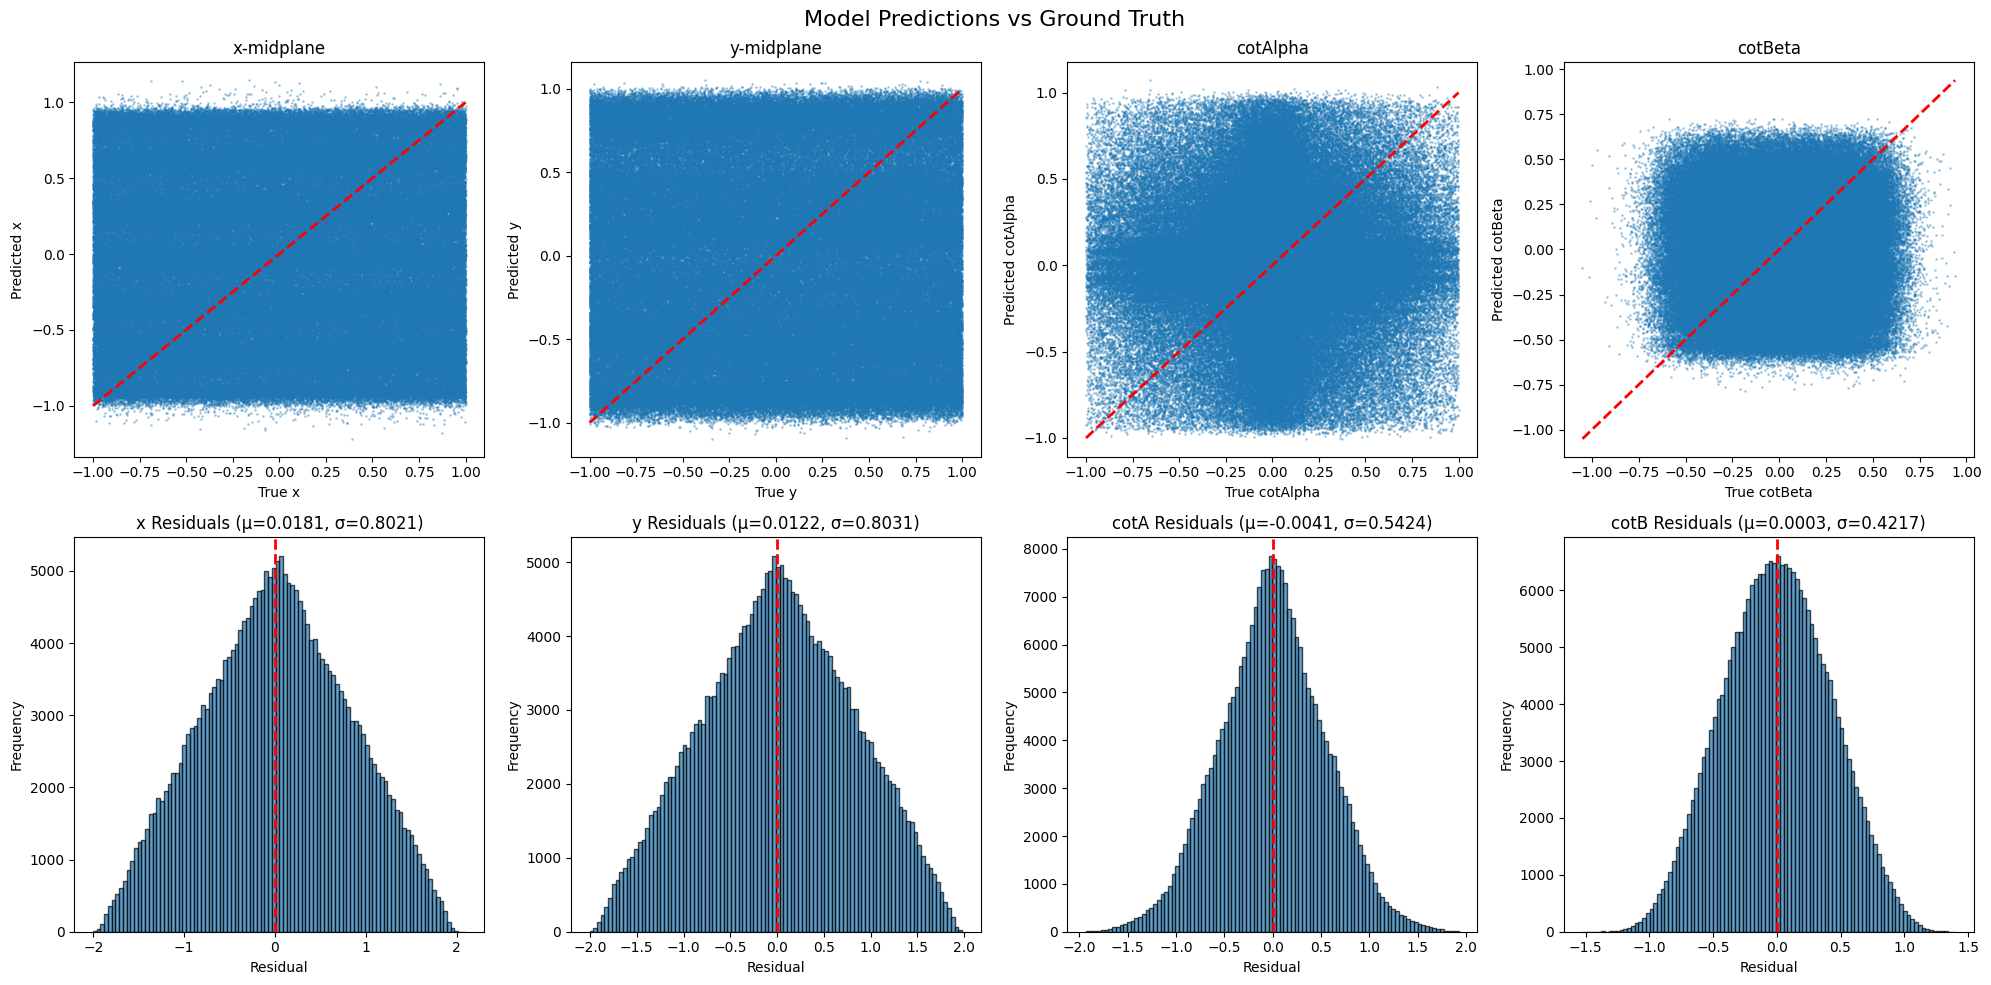


=== Summary Statistics ===

x-midplane:
  Mean residual: 0.018091
  Std residual:  0.802142
  RMSE:          0.802344

y-midplane:
  Mean residual: 0.012234
  Std residual:  0.803076
  RMSE:          0.803168

cotAlpha:
  Mean residual: -0.004059
  Std residual:  0.542402
  RMSE:          0.542416

cotBeta:
  Mean residual: 0.000314
  Std residual:  0.421666
  RMSE:          0.421665


In [15]:
# Read the results
test_result = pd.read_csv("/home/hep/ac5222/Project/smart-pixels-ml-2/outfile_3e778b82/evaluation_results_weights.117-t-1220.46-v-1137.35.csv")

# Calculate residuals
test_result['residual_x'] = test_result['xtrue'] - test_result['x']
test_result['residual_y'] = test_result['ytrue'] - test_result['y']
test_result['residual_cotA'] = test_result['cotAtrue'] - test_result['cotA']
test_result['residual_cotB'] = test_result['cotBtrue'] - test_result['cotB']

# Set up the figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Model Predictions vs Ground Truth', fontsize=16)

# Plot 1: x prediction vs true
axes[0, 0].scatter(test_result['xtrue'], test_result['x'], alpha=0.3, s=1)
axes[0, 0].plot([test_result['xtrue'].min(), test_result['xtrue'].max()], 
                [test_result['xtrue'].min(), test_result['xtrue'].max()], 'r--', lw=2)
axes[0, 0].set_xlabel('True x')
axes[0, 0].set_ylabel('Predicted x')
axes[0, 0].set_title('x-midplane')

# Plot 2: y prediction vs true
axes[0, 1].scatter(test_result['ytrue'], test_result['y'], alpha=0.3, s=1)
axes[0, 1].plot([test_result['ytrue'].min(), test_result['ytrue'].max()], 
                [test_result['ytrue'].min(), test_result['ytrue'].max()], 'r--', lw=2)
axes[0, 1].set_xlabel('True y')
axes[0, 1].set_ylabel('Predicted y')
axes[0, 1].set_title('y-midplane')

# Plot 3: cotA prediction vs true
axes[0, 2].scatter(test_result['cotAtrue'], test_result['cotA'], alpha=0.3, s=1)
axes[0, 2].plot([test_result['cotAtrue'].min(), test_result['cotAtrue'].max()], 
                [test_result['cotAtrue'].min(), test_result['cotAtrue'].max()], 'r--', lw=2)
axes[0, 2].set_xlabel('True cotAlpha')
axes[0, 2].set_ylabel('Predicted cotAlpha')
axes[0, 2].set_title('cotAlpha')

# Plot 4: cotB prediction vs true
axes[0, 3].scatter(test_result['cotBtrue'], test_result['cotB'], alpha=0.3, s=1)
axes[0, 3].plot([test_result['cotBtrue'].min(), test_result['cotBtrue'].max()], 
                [test_result['cotBtrue'].min(), test_result['cotBtrue'].max()], 'r--', lw=2)
axes[0, 3].set_xlabel('True cotBeta')
axes[0, 3].set_ylabel('Predicted cotBeta')
axes[0, 3].set_title('cotBeta')

# Plot 5-8: Residual distributions
axes[1, 0].hist(test_result['residual_x'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'x Residuals (μ={test_result["residual_x"].mean():.4f}, σ={test_result["residual_x"].std():.4f})')
axes[1, 0].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 1].hist(test_result['residual_y'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'y Residuals (μ={test_result["residual_y"].mean():.4f}, σ={test_result["residual_y"].std():.4f})')
axes[1, 1].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 2].hist(test_result['residual_cotA'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Residual')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title(f'cotA Residuals (μ={test_result["residual_cotA"].mean():.4f}, σ={test_result["residual_cotA"].std():.4f})')
axes[1, 2].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 3].hist(test_result['residual_cotB'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 3].set_xlabel('Residual')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].set_title(f'cotB Residuals (μ={test_result["residual_cotB"].mean():.4f}, σ={test_result["residual_cotB"].std():.4f})')
axes[1, 3].axvline(0, color='r', linestyle='--', lw=2)

plt.tight_layout()
plt.savefig('test_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"\nx-midplane:")
print(f"  Mean residual: {test_result['residual_x'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_x'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_x']**2).mean()):.6f}")

print(f"\ny-midplane:")
print(f"  Mean residual: {test_result['residual_y'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_y'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_y']**2).mean()):.6f}")

print(f"\ncotAlpha:")
print(f"  Mean residual: {test_result['residual_cotA'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_cotA'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_cotA']**2).mean()):.6f}")

print(f"\ncotBeta:")
print(f"  Mean residual: {test_result['residual_cotB'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_cotB'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_cotB']**2).mean()):.6f}")